# Practical extreme value analysis applied to precipitation

### Lecturer: Ruud van der Ent
In this practical you will use statistics to analyse extreme precipitation. There are 7 sections, please do not hurry, but read everything carefully. Some sections have small exercises associated with them. Behind all sections is the indicative time it costs to complete. Of course it is not forbidden to be faster or slower.

## 1. Introduction
In the rainfall duration curves that you have created in ENVM1400 you have noticed that it was impossible or at least quite tricky to estimate the intensity of events that have a longer return period compared to the period of observation. In order to get more reliable estimates of extremes with higher return periods we use extreme value analysis (EVA). 

In EVA, the first step is to filter your data for which we can distinguish three main methods: 
- Block Maxima (BM), where the block is taken usually taken as 1 year (thus, annual maxima, AM);
- Peaks over Threshold (POT) method, which uses all events above a certain threshold;
- Recently developed method called the Metatistatistical Extreme Value (MEV) method, which uses all rainy days in a block to infer block maxima. 

As a second step, we consequently have to assume that our 'observed' values to belong to a statistical distribution. In this class we will work with AM (Gumbel and GEV) and the MEV method. We skip the POT methods as usually the results are quite similar to GEV, especially for large return periods. 

**Remember that EVA is just a tool.** You can apply it and use it to your advantage, but in the end it is you as a human hydrological expert that has to provide the interpretation and not the artificial intelligence. General problems that arise with all methods are: 
- Our observations are just a small sample of the 'true' distribution, thus the required series should be long enough to get obtain reliable estimates;
- Observations contain missing or unreliable data: what went wrong, was the rainfall so extreme that it gave an error or did the battery die? Did somebody flush the rain gauge with water? Are there systematic biases?;
- Observation series should be homogenous (different instruments!);
- Observation series should be stationary (climate change!);
- Observation series should be independent (station reporting times during events; El Niño years);
- The observations may in reality come from a mixture of distributions due the fact that precipitation has different physical drivers yielding different precipitation types;
- The 'real' distribution may not be adequately described by the assumed distribution. It may be better described by another distribution.
- Different fitting methods exist to fit the distribution. Which one is best? Although this point is usually the least of your problems compared to of all problems above, this issue receives a lot of attention in statistical literature (you be the philosopher of why that is).

Note that in "CEGM1000 MUDE" you have already worked with the GEV and POT approaches and you may remember the Gumbel distribution from "CTB2420 Hydrologie" or an equivalent BSc course. Here, we are going to quickly recap your knowledge and skills regarding these methods. First, we will spend a bit more time on fitting Gumbel with a relatively old-fashioned graphical procedure. This is aimed at helping you to understand what is going on behind the scenes when we're fitting any extreme value distribution to the data. 

1. Introduction and data pre-processing: 15 minutes

2. Gumbel using the graphical procedure: 45 minutes

Have a break!

3. GEV: 15 minutes

4. MEV: 45 minutes

Have another break!
    
5. Compare full series, Gumbel, GEV, and MEV: 30 minutes

**Reflect for 15 minutes on your results before going home or work ahead with sections 6 and 7**

**At the end of the lecture of 25 March there will be some time remaining to finish the remaining sections as well**

6. Monte Carlo testcase for GEV and MEV estimates: 30 minutes   
    
7. Reflective questions: 15 minutes 



**The goals of this exercise are to:**
- Apply different extreme value analysis (EVA) using different extreme value distributions and methods.
- Understand the differences between the Gumbel, GEV and MEV distributions


The first step is to load some standard python packages (numpy, pandas, scipy and matplotlib.pyplot).

The package mevpy is created by Enrico Zorzetto and needs to be in the same folder as this notebook. The latest version of mevpy is on Brightspace, and an older version is found on github: https://github.com/EnricoZorzetto/mevpy. Don't change anything in the mevpy package unless you are an expert user. 

In [2]:
# import necessary packages
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import mevpy as mev # only works when this folder is in the folder of this .ipnyb-file
import warnings
import random
warnings.simplefilter('ignore') # filter some warning messages

### 1.1	Definitions
Different symbols are being used in various literature sources. Here, we stick to the following definitions:
- $c$ = number of events in interval t
- $d$ = length of the record (in days)
- $F(x)$ = cumulative distribution function of the variable x (This is the same as the probability of non-exceedance)
- $i$ = ranking of annual extremes 
- $k$ = duration (in days)
- $M$ = length of the record (in years) 
- $n_\text{occ}$ = number of times that an event within the class occurs
- $n_\text{ex}$ = number of times that the bottom of the class is being exceeded
- $P()$ = probability in a general sense, between brackets we specify which probability we want to express.
- $p$ = annual probability of exceedance of a certain precipitation event
- $q$ = annual probability of non-exceedance of a certain precipitation event
- $R$ = rainfall/precipitation (usually we use $P$, but now $R$ to avoid the confusion with probability)
- $R_\text{max}$ = maximum precipitation in a block
- $r$ = rate of occurrence (1/time)
- $s$ = standard deviation
- $T$ = Return period (a frequency scale) of exceeding a certain precipitation event (1/year)
- $T_a$ = return period of annual extremes (1/year)
- $x$ = general variable to be estimated
- $t$ = time interval
- $\mu$ = location parameter (not necessarily the mean!)
- $\sigma$ = scale parameter (not necessarily the standard deviation!)
- $\xi$ = shape parameter
- $y$ = reduced variate
- $N$ = Number of wet days per year (used in MEV-Weibull)
- $C$ = scale parameter of the (MEV-)Weibull distribution (not necessarily the standard deviation!)
- $W$ = shape parameter of the (MEV-)Weibull distribution
- $\zeta(x)$ = cumulative distribution function of the variable x for MEV-Weibull
- $H(x)$ = cumulative distribution function of the variable x for in individual year with Weibull fitted through the wet days

### 1.2 Data pre-processing
In this exercise we use the Multi-Source Weighted-Ensemble Precipitation version 2 (MSWEP v2) data set (Beck et al., 2018). The data provide daily precipitation values on 0.1° latitude × 0.1° longitude for the period 1979-2017. The data can be found on Brightspace. You can choose from different locations for your analysis. 

Make sure your csv file is in the same folder as this python notebook. Use pandas to create a dataframe of the csv file, and set the column 'time' as the datetime-index of the dataframe.

In [3]:
# insert the filename
#filename = 'data_exercises/Precipitation_Australia_Sydney.csv'

# create a dataframe from the file
#prcp_df = pd.read_csv(filename, skiprows=[1], skipinitialspace=True, index_col=0, parse_dates=True) 
#Load in Camel Precipitation Data
df_camel = pd.read_csv('../Data/Prep_Camel_SILO.csv')
df_camel['time'] = pd.to_datetime(df_camel[['year', 'month', 'day']])
df_camel.drop(['day', 'year', 'month'], axis= 1, inplace = True)
df_camel.set_index('time', inplace=True)
prcp_df = pd.DataFrame(df_camel['212260'])
prcp_df.rename(columns={'212260': 'PRCP'}, inplace= True)

# add a column containing YEAR for clarity
prcp_df['YEAR'] = prcp_df.index.year


Look into the first 10 lines.

In [4]:
# exercise, inspect the first ten lines of the data
prcp_df.tail(10)

,PRCP,YEAR
time,,
2018-12-22,0.690831,2018
2018-12-23,0.010423,2018
2018-12-24,0.000000,2018
2018-12-25,0.000215,2018
2018-12-26,0.000000,2018
2018-12-27,0.000000,2018
2018-12-28,0.096275,2018
2018-12-29,0.349248,2018
2018-12-30,0.000000,2018


## 2 Gumbel
Historically the Gumbel type 1 distribution, also simply known as the Gumbel distribution, is widely used by hydrologists for the estimation of precipitation and discharge extremes. In recent years this method has often been replaced by GEV. We will discuss the reason for that in the GEV distribution exercise. First, you will again build the return level plots for your rainfall series based on the Gumbel distribution. In this exercise we will only do this for daily precipitation.

The fundamental Gumbel-theorem can be stated as: if $x_1$, $x_2$, $x_3$, ... $x_n$ are independent extreme values observed in $n$ samples of equal size $N$ (e.g., years), and if $x$ is an unlimited exponentially-distributed variable, then as $n$ and $N$ approach infinity, the cumulative probability that any of the extremes will be less than a given value $x_i$ is given by:

$F(x;\mu ,\sigma )=q=\exp \left( -\exp (-\frac{x-\mu }{\sigma }) \right)$

Where the reduced variate is defined by:

$y=\frac{x-\mu }{\sigma }=-\ln \left( -\ln (q) \right)$ 

For the definition of the parameters see Section 1.1.
In this case your variable $x$ is the annual precipitation maximum $R_\text{max}$. 

Below we are going to stepwise fit a Gumbel distribution to your data series, which remember we stored in a dataframe called `prcp_df`

In [5]:
# Here is an adapted function to sample annual maxima from CEGM1400 that you may use
def annual_maxima(data):
    idx_max = data.groupby(data.index.year)['PRCP'].idxmax()
    max_list = data.loc[idx_max]
    return max_list

In [6]:
# exercise: call the annual maxima function and store your data show your list of annual maxima
year_max = annual_maxima(prcp_df)

year_max

,PRCP,YEAR
time,,
1900-07-06,102.534315,1900
1901-08-21,64.817873,1901
1902-12-16,30.896204,1902
1903-09-18,43.277723,1903
1904-07-10,84.068412,1904
...,...,...
2014-08-18,53.905839,2014
2015-04-21,49.889256,2015
2016-06-05,92.422065,2016


In [7]:
# exercise: write a code to sort your annual maxima from highest to lowest rainfall and store in a new dataframe
# tip: use pandas.DataFrame.sort_values
df_max = year_max.sort_values(by = 'PRCP', ascending=False)

df_max

,PRCP,YEAR
time,,
1978-03-20,193.181165,1978
1967-08-07,140.839904,1967
1986-08-06,134.087287,1986
1922-07-25,130.153083,1922
1988-07-06,120.839222,1988
...,...,...
1905-07-10,26.696598,1905
1939-08-03,25.932092,1939
1979-03-15,24.864578,1979


Exercise: calculate the following aspects:
- $M$ = length of the record (in years) 

Then, expand your annual maxima dataframe with the following column:
- $i$ = ranking of annual extremes 

This you can use to assign a probability to the observed events, which is known as the plotting position and add that column as well. We use plotting position $p = \frac{i}{M+1}$
- $p$ = annual probability of exceedance of a certain precipitation event

Subsequently you can easily add the following columns:
- $q$ = annual probability of non-exceedance of a certain precipitation event
- $y$ = reduced variate
- $T_a$ = return period of annual extremes (1/year)

In [9]:
#exercise, calculate N and expand you annual maxima dataframe with the columns i, p, q, q, T_a

M = len(df_max)
i = np.arange(1,120)
p = i / (M+1)
q = 1 - p
y = -np.log(-np.log(q))
T_a = 1/ p

df_max['i'] = i
df_max['p'] = p
df_max['q'] = q
df_max['y'] = y
df_max['T_a'] = T_a

df_max


,PRCP,YEAR,i,p,q,y,T_a
time,,,,,,,
1978-03-20,193.181165,1978,1,0.008333,0.991667,4.783311,120.000000
1967-08-07,140.839904,1967,2,0.016667,0.983333,4.085953,60.000000
1986-08-06,134.087287,1986,3,0.025000,0.975000,3.676247,40.000000
1922-07-25,130.153083,1922,4,0.033333,0.966667,3.384294,30.000000
1988-07-06,120.839222,1988,5,0.041667,0.958333,3.156849,24.000000
...,...,...,...,...,...,...,...
1905-07-10,26.696598,1905,115,0.958333,0.041667,-1.156269,1.043478
1939-08-03,25.932092,1939,116,0.966667,0.033333,-1.224128,1.034483
1979-03-15,24.864578,1979,117,0.975000,0.025000,-1.305323,1.025641


According to the theory of Gumbel these observations should plot on a straight line against the reduced variate. My data is all stored in `annual_maxima_df_sorted`, but this may of course have a different name in your code.
Let's have a look at the reduced variate vs annual maxima precipitation:

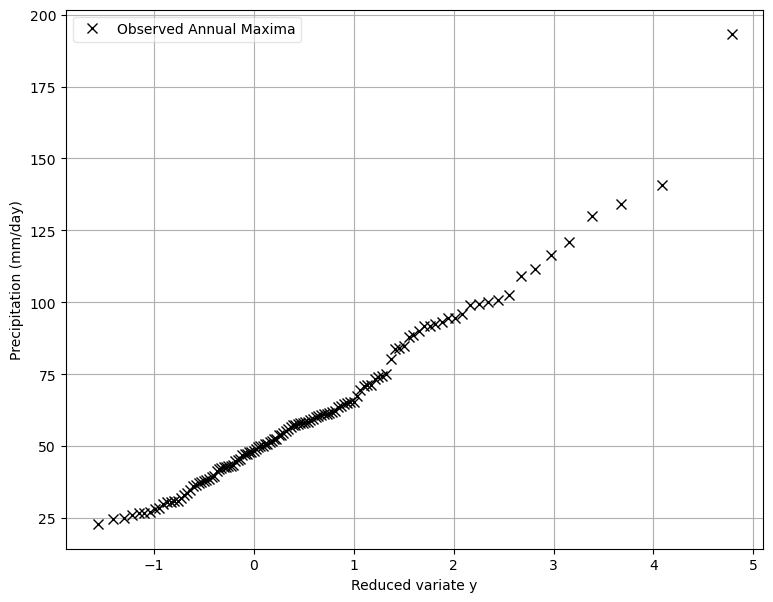

In [10]:
# exercise: plot the reduced variate y against the annual maxima
# change the name of the dataframe in the code below to what you used, 
# or rename your own dataframe to get this code running
fig, ax = plt.subplots(figsize=(9,7))
ax.plot(df_max['y'].values, df_max['PRCP'].values, \
        'xk', markersize=7, label='Observed Annual Maxima') 
ax.set_xlabel('Reduced variate y')
ax.set_ylabel('Precipitation (mm/day)')
ax.legend(loc='best',framealpha=0.5)
ax.grid(True)

Almost there, now we just have to fit a straight line from which we can obtain the parameters $\mu$ and $\sigma$ of the Gumbel distribution. Can you imagine how hydrologists used to do this on paper before computers were invented, pretty smart right? Here, let's use some quick estimators using the mean and standard deviation of the sample and the reduced variate:

${{R}_{\text{Gumbel} }}=\sigma y+\mu $

$\sigma =\frac{{{s}_{R}}}{{{s}_{y}}}$

$\mu =\overline{{{R}_{\max }}}-{{s}_{R}}\frac{\overline{y}}{{{s}_{y}}}$

Where $s_y$ and $s_R$ are the standard deviation of the reduced variate and the sample respectively.


In [11]:
# exercise: compute Gumbel parameters (name them sigma and mu)
s_R = df_max['PRCP'].std()
s_y = df_max['y'].std()
y_gem = df_max['y'].mean()
R_max_gem = df_max['PRCP'].mean()



sigma = s_R / s_y
mu = R_max_gem - s_R * (df_max['y'].mean() / s_y)



print('scale parameter σ = ' + str(sigma))
print('location parameter µ = ' + str(mu))

scale parameter σ = 23.312235259648485
location parameter µ = 48.400690007174425


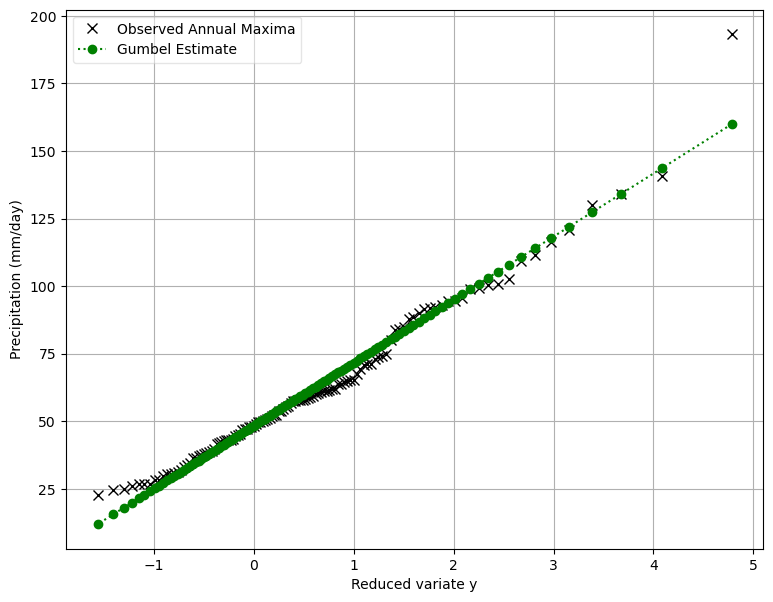

In [12]:
# Now we can construct the Gumbel fit and plot the Gumbel line
dummy_y = np.arange(-2,6.01,0.2)
R_Gumbel = sigma * y + mu

fig, ax = plt.subplots(figsize=(9,7))
ax.plot(df_max['y'].values, df_max['PRCP'].values, \
        'xk', markersize=7, label='Observed Annual Maxima')
ax.plot(y, R_Gumbel, \
        ':og', label = 'Gumbel Estimate')
ax.set_xlabel('Reduced variate y')
ax.set_ylabel('Precipitation (mm/day)')
ax.legend(loc='best',framealpha=0.5)
ax.grid(True)

#### 2.1 Return periods of interest
Of course we want to translate this back into a return level plot to make it easier to interpret. Let's specify some return periods ($T$) we are interested in: 0.2, 0.5, 1, 1.2, 1.5, 2, 5, 10, 20, 35, 50, 100, 200, 500 and 1000 years. Often ignored, but note that these return periods are slightly different from the return periods of an annual maximum, because you could imagine that the lowest annual maxima also occur during years with higher annual maxima. Since rainfall can be assumed to be Poisson distributed, the actual return period $T$ can be estimated from $T_a$:

$T=\frac{-1}{\ln (1-\frac{1}{{{T}_{a}}})}$

And the other way:
	  
${{T}_{a}}=\frac{1}{1-\exp (-\frac{1}{T})}$

,PRCP,YEAR,i,p,q,y,T_a,T
time,,,,,,,,
1978-03-20,193.181165,1978,1,0.008333,0.991667,4.783311,120.0,119.499303
1967-08-07,140.839904,1967,2,0.016667,0.983333,4.085953,60.0,59.498599
1986-08-06,134.087287,1986,3,0.025000,0.975000,3.676247,40.0,39.497890
1922-07-25,130.153083,1922,4,0.033333,0.966667,3.384294,30.0,29.497175
1988-07-06,120.839222,1988,5,0.041667,0.958333,3.156849,24.0,23.496453


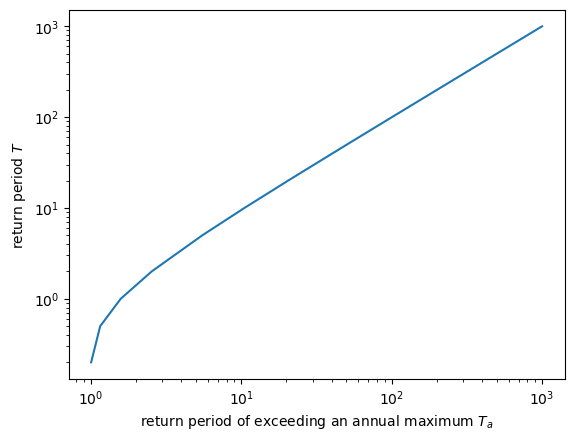

In [13]:
# Here we define the return periods and we inspect the difference between the two return periods
T_interest = np.asarray([0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000])
T_a_interest = 1 / (1-np.exp(-1/T_interest))
plt.loglog(T_a_interest,T_interest)
plt.xlabel('return period of exceeding an annual maximum $T_a$')
plt.ylabel('return period $T$')

# real return period for the observed annual maxima
T_a = 1 / p
df_max.loc[:,'T_a'] = T_a
T = -1 / np.log(1 - 1/df_max['T_a'].values)
df_max.loc[:,'T'] = T
df_max.head(5)

As you can see $T_a$ does not go below 1 and for large return periods the use of $T_a$ or $T$ is not so relevant, hence many people take a shortcut and disregard this difference. Using the array of $T_a$, we can explicitly compute the corresponding Gumbel estimates, by substitution:

${{R}_{\text{Gumbel} }}=\sigma y+\mu $

with:

$y = -\ln(-\ln(q))$

and:

$q = 1 - \frac{1}{T_a}$

giving

${{R}_{\text{Gumbel}}}=\sigma \left( -\ln \left( -\ln (1-\frac{1}{T_a}) \right) \right)+\mu $

further simplifying to

${{R}_{\text{Gumbel}}}=\sigma \left( -\ln (\frac{1}{T}) \right)+\mu $


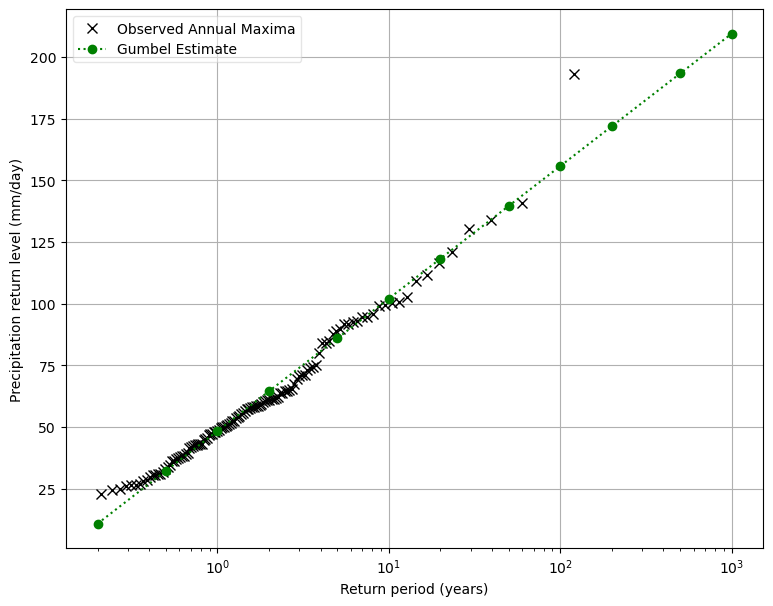

In [14]:
# exercise, Gumbel estimate for return period array T_interest



gumbel_estimate = sigma * (-np.log(1/T_interest)) + mu




# create the figure
fig, ax = plt.subplots(figsize=(9,7))
ax.plot(T, df_max['PRCP'].values, \
        'xk', markersize=7, label='Observed Annual Maxima')
ax.plot(T_interest, gumbel_estimate, ':og', label = 'Gumbel Estimate')
ax.set_xlabel('Return period (years)')
ax.set_ylabel('Precipitation return level (mm/day)')
ax.set_xscale('log')
ax.legend(loc='best',framealpha=0.5)
ax.grid(True)

***What do you think of the Gumbel fit? Perhaps we can do better using some other approaches ...}***

## 3 GEV
Whereas the Gumbel distribution only has 2 parameters, the GEV distribution has 3 parameters. The cumulative probability that any of the extremes will be less than a given value $x_i$ is given by: 

$F(x;\mu ,\sigma ,\xi )=\left\{ \begin{align}
  & \exp \left( -{{(1+\xi y)}^{\frac{-1}{\xi }}} \right)\text{         }\;\:\:,\xi \ne \text{0 } \\ 
 & \exp \left( -\exp (-y) \right)\text{            }\;\;\;\;\;\;\;,\xi =0 \\ 
\end{align} \right.$

The tail behavior of the different distribution families has been discussed during the lectures. Refer back to this in case you forgot.

In order to compute the GEV we again need the annual maxima series (AMS) for our precipitation data which we already have. 

So, let's estimate the three GEV parameters:

- GEV shape parameter    = $\xi$
- GEV scale parameter    = $\sigma$
- GEV location parameter = $\mu$

The function `mev.gev_fit(AMS)` estimates the GEV parameters automatically based on L-moments.

In [15]:
# fit GEV parameters (withhout overwriting the sigma and mu from Gumbel)
AMS = df_max['PRCP'].values
xi, sigma_gev, mu_gev = mev.gev_fit(AMS)

Great, we have the GEV-parameters. However, we are still interested to explicitly compute the precipitation return levels corresponding to the return periods `T_interest` above. Let's check that we still have that variable correctly stored and compute the corresponding cumulative distribution function `F_interest`. Recall, that $F$ equals $q$, which is the probability of not exceeding a certain extreme value. 

$T_a = \frac{1}{p} = \frac{1}{1 - q}$

from which it follows that by substiting the righthandside into the second formula of section 2.1

$F = q = \exp(- \frac{1}{T})$

or going back to the theory from ENVM1400:

$P(\ge 1 \text{ event exceeding } x \text{ in 1 year}) = 1 - P(0 \text{ events exceeding } x \text{ in 1 year})$

thus

$F = q = P(0 \text{ events exceeding } x \text{ in 1 year}) = \exp(- \frac{1}{T})$

In [16]:
# corresponding non-exceedance probabilities
F_interest = np.exp(-(1/T_interest))
# check what you created:
print('T_interest = ' + str(T_interest))
print('F_interest = ' + str(F_interest))

T_interest = [2.e-01 5.e-01 1.e+00 2.e+00 5.e+00 1.e+01 2.e+01 5.e+01 1.e+02 2.e+02
 5.e+02 1.e+03]
F_interest = [0.00673795 0.13533528 0.36787944 0.60653066 0.81873075 0.90483742
 0.95122942 0.98019867 0.99004983 0.99501248 0.998002   0.9990005 ]


Using the function `mev.gev_quant(F, xi, sigma_gev, mu_gev)` we explicitly compute the GEV estimates for our return periods of interest.

In [17]:
# calculate the GEV estimate for our return periods of interest
gev_estimate = mev.gev_quant(F_interest, xi, sigma_gev, mu_gev)

# convert to dataframe and make a nice table
df_gev_estimate = pd.DataFrame(gev_estimate,columns=['GEV estimate (mm/day)'])
df_gev_estimate.index = T_interest # Return Period
df_gev_estimate

,GEV estimate (mm/day)
0.2,18.330602
0.5,34.739629
1.0,48.090055
2.0,62.306049
5.0,82.522829
10.0,98.971253
20.0,116.486101
50.0,141.394230
100.0,161.659549
200.0,183.238758


Now, expand your return level plot that you made for the Gumbel analysis with the GEV estimate. 

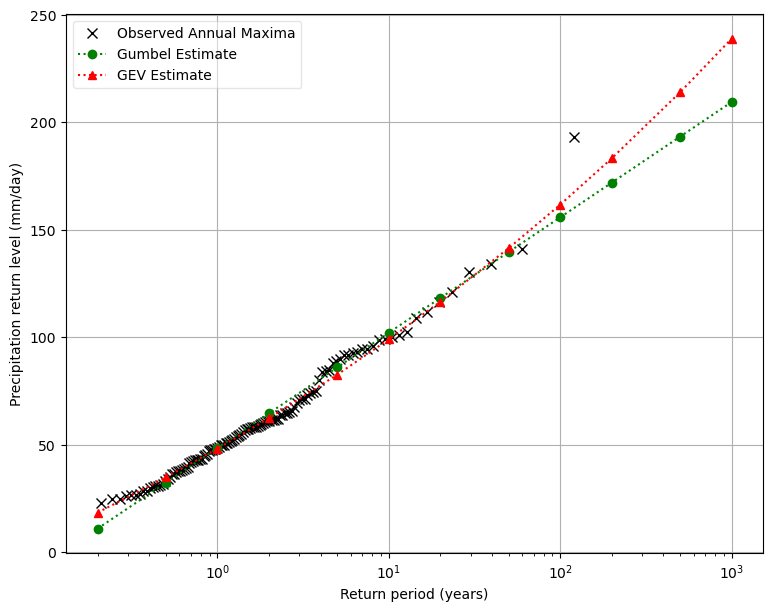

In [18]:
# create the figure
fig, ax = plt.subplots(figsize=(9,7))
ax.plot(T, df_max['PRCP'].values, \
        'xk', markersize=7, label='Observed Annual Maxima')
ax.plot(T_interest, gumbel_estimate, ':og', label = 'Gumbel Estimate')
ax.plot(T_interest, gev_estimate, ':^r', label='GEV Estimate')
ax.set_xlabel('Return period (years)')
ax.set_ylabel('Precipitation return level (mm/day)')
ax.set_xscale('log')
ax.legend(loc='best',framealpha=0.5)
ax.grid(True)

***What do you think of these lines? Does the GEV better fit the data? What do you think of the extrapolation?***

## 4 MEV

MEV stands for Metastatistical Extreme Value distribution. The MEV uses the full distribution of the data, so it also includes the information of the "ordinary" rainfall events to estimate the extremes. The Weibull distribution is fitted to the annual data, whereafter the MEV is computed. 

The MEV-Weibull has the following parameters:

- Dimension of the sample = $N$ ( = number of wet days, i.e. above the threshold of 1 mm/day) 
- Weibull scale parameter = $C$
- Weibull shape parameter = $W$

The function __mev.mev_fit(dataframe, threshold=1)__ estimates the MEV parameters automatically based on Probability Weighthed Moments.

In [19]:
# fit mev parameters for each year
N, C, W =  mev.mev_fit(prcp_df, threshold=1)

# put this into a nice dataframe
df_params_mev = pd.DataFrame([N,C,W]).transpose()
df_params_mev.columns = ['N','C','W']
df_params_mev.head(10)


,N,C,W
0,139.0,7.617681,0.755365
1,116.0,6.467314,0.842899
2,87.0,5.831384,1.024007
3,129.0,6.891554,1.040106
4,108.0,7.461965,0.810212
5,124.0,5.785662,1.021004
6,115.0,6.216096,0.894786
7,108.0,5.626789,0.963643
8,121.0,5.990141,0.927330
9,105.0,6.263767,0.909656


Let's visualize what we have computed so far. 

For the $N$, $C$ and $W$ parameters that you have just computed, we create histograms like in Figure 1 of in Zorzetto et al. (2016), the top right blue, red and green histograms.

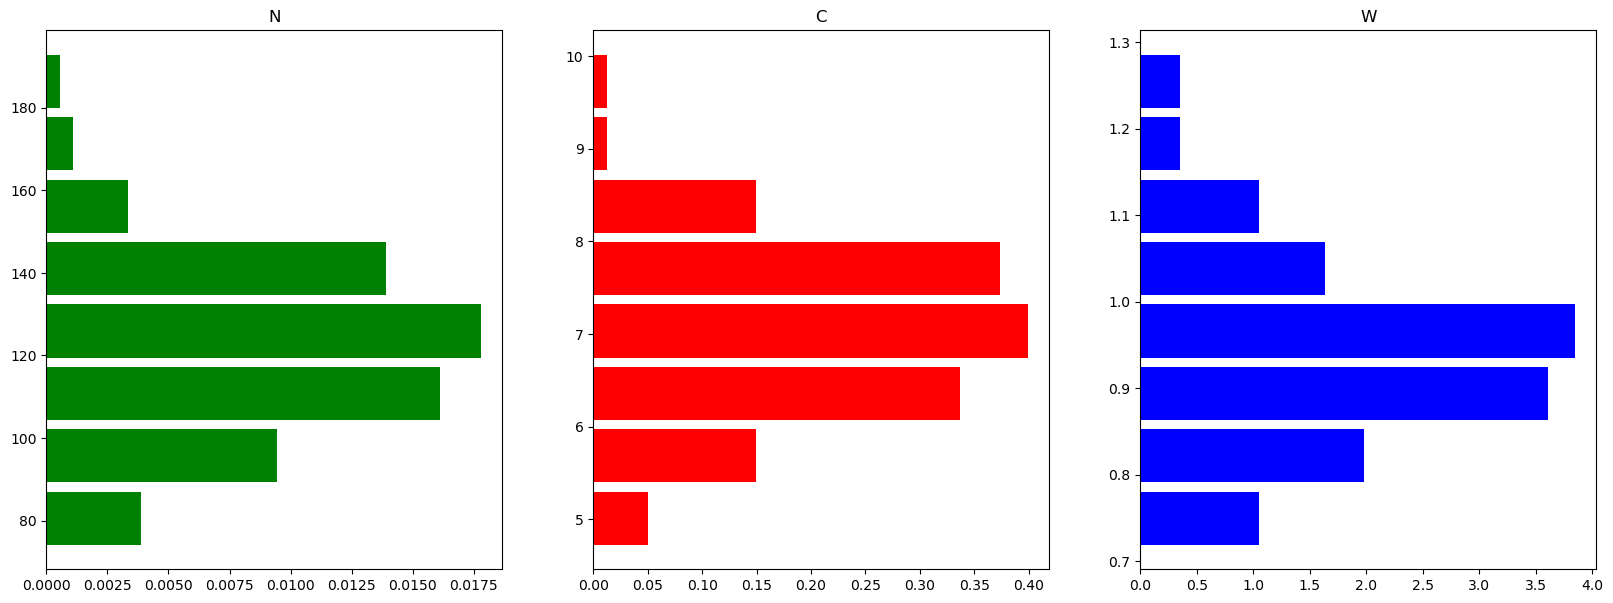

In [20]:
# histograms
params = 'N','C','W'
colors = 'g','r','b'
fig, ax = plt.subplots(1,3, figsize=(20,7))
for a in range(3):
    my_param = params[a]
    my_color = colors[a]
    ax[a].hist(df_params_mev[my_param], rwidth=0.85, density=True, bins=8, 
                                 orientation='horizontal', color=my_color)
    ax[a].set_title(params[a])

### 4.1 - Exercise: visualize the MEV CDF 
Having the $N$, $C$ and $W$ parameters. For each individual year also plot the cumulative distribution function (CDF). **To do so, first create a table of precipitation versus non-exceedance probability $F$.** A code for plotting is already given in the cell after.

NOTE: there is a typo in Zorzetto et al. (2016). Their Eq. (3) should read: 

$\zeta_m (x) = \frac{1}{M} \sum_{j=1}^{M} \left( 1-\rm{exp}\left[ - \left( \frac{x}{C_j} \right) ^{W_j} \right] \right) ^{N_j}$

The CDF of an individual year is given by:

$H_j (x;C_j,W_j,N_j) = \left( 1-\rm{exp}\left[ - \left( \frac{x}{C_j} \right) ^{W_j} \right] \right) ^{N_j}$


In [21]:
# exercise: create your own code for plotting the CDF curves
dummy_X = np.arange(0,1000,2)

# non-exceedance probability for individual years (here defined as H)
H = np.zeros((len(dummy_X),M))
zeta = np.zeros((len(dummy_X)))

# continue with your own code here:
for i in range(len(df_params_mev)):
   for j in range(len(dummy_X)):
      H[j,i] = (1- np.exp(-(dummy_X[j]/ df_params_mev['C'][i])** df_params_mev['W'][i]))**df_params_mev['N'][i]
    
for i in range(len(dummy_X)):
   zeta[i] = (1/M) * np.sum((1 - np.exp(-(dummy_X[i] / df_params_mev['C'])**df_params_mev['W']))**df_params_mev['N'])

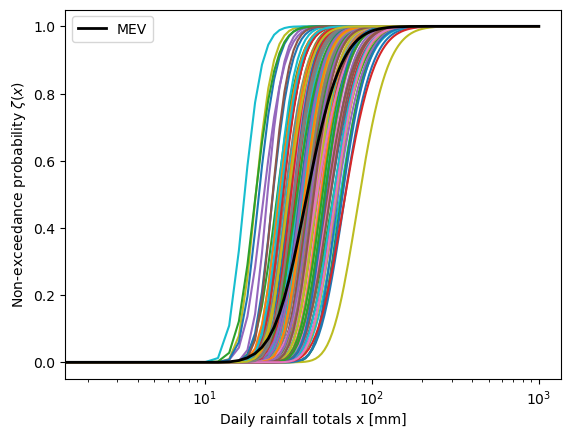

In [22]:
# plot figure like in Enrico's paper
fig, ax = plt.subplots()
ax.plot(dummy_X, H)
ax.plot(dummy_X, zeta, 'k', linewidth=2, label='MEV')
ax.set_xlabel('Daily rainfall totals x [mm]')
ax.set_ylabel('Non-exceedance probability $\zeta(x)$')
ax.set_xscale('log')
ax.legend()

### 4.2 MEV Estimate
Compute the amounts of precipitation corresponding to the different return periods of interest($T$).

Use the function __mev.mev_quant($q$, $x0$, $N$, $C$, $W$)__ to calculate the MEV estimate. 

Note that the MEV does not have an analytical solution, therefore, we must compute it numerically. The parameter $x0$ is the starting guess for the numerical solution of the MEV. The mean of the annual maxima would be a good initial guess for $x0$. If, however, if the algorithm could not find a solution, an error will be raised and one of the flags will show True. In this case you need to change $x0$.

In [23]:
# exercise, obtain the MEV solution
#x0 = np.mean(AMS)
x0 = 30
mev_estimate, flags =  mev.mev_quant(F_interest, x0, N, C, W)

if any(flags) == True:
    print('Change starting guess for the numerical solution x0')
elif any(flags) == False:
    print('No errors have been raised, continue the exercise')

No errors have been raised, continue the exercise


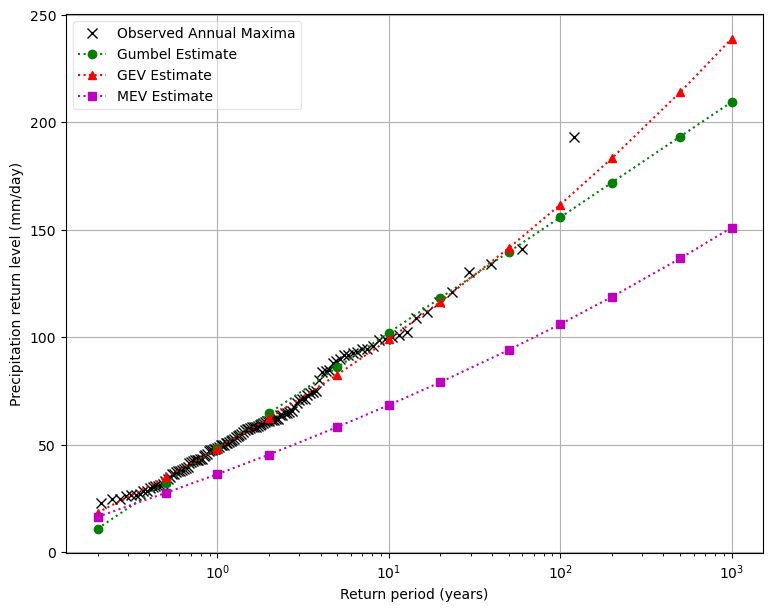

In [24]:
# Now we can expand our plot and compare all EVA methods!
fig, ax = plt.subplots(figsize=(9,7))
ax.plot(T, df_max['PRCP'].values, \
        'xk', markersize=7, label='Observed Annual Maxima')
ax.plot(T_interest, gumbel_estimate, ':og', label = 'Gumbel Estimate')
ax.plot(T_interest, gev_estimate, ':^r', label='GEV Estimate')
ax.plot(T_interest, mev_estimate, ':sm', label='MEV Estimate')
ax.set_xlabel('Return period (years)')
ax.set_ylabel('Precipitation return level (mm/day)')
ax.set_xscale('log')
ax.legend(loc='best',framealpha=0.5)
ax.grid(True)


## 5 Compare full series, Gumbel, GEV, and MEV

Remember that in ENVM1401 we also created return level plots without any extreme value distribution. It would be nice to compare return levels from that method with those from the extreme value analysis

In [25]:
#Set-up Frequency Dataframe
depths = np.arange(1,250) # note the depth might need to be increased depending on the location and corresponding extreme rainfall and the duration
columns = ['n_occ_1day', 'n_ex_1day', 'r_ex_1day', 'T_1day']
frequency_df = pd.DataFrame(index=depths, columns=columns)
frequency_df.index.name = 'sum(R) (mm)'
frequency_df

,n_occ_1day,n_ex_1day,r_ex_1day,T_1day
sum(R) (mm),,,,
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN
...,...,...,...,...
245,NaN,NaN,NaN,NaN
246,NaN,NaN,NaN,NaN
247,NaN,NaN,NaN,NaN


In [26]:
# exercise, create and import the depth duration frequency curve data that you obtained based on the full series
# of course this only works with the same data from the same station, so change the station in your ENVM1401 notebook.
 #Create Station Dataframe
station = prcp_df['PRCP'].copy()
station = pd.DataFrame(station)
station = station.rename(columns={"PRCP": "R-1day"})

# remove all values below 1 mm/day and save as separate column
station['R-1day-nonzero'] = station['R-1day']
station['R-1day-nonzero'][station['R-1day-nonzero'] < 1] = np.nan
station

# extract the actual values from the timeseries
R_1_day_nonzero = station['R-1day-nonzero'].values

# compute the count and the bin edges (including left and right edges)
extended_bin_edges = np.append(depths, depths[-1] + depths[-1]-depths[-2])
count, bin_edges_check = np.histogram(R_1_day_nonzero, bins=extended_bin_edges)

# put this back in the original dataframe 'frequency_df'
frequency_df['n_occ_1day'] = count
frequency_df

# total number of years
d = len(station)
N = d / 365.25
print('total number of years N = ' + str(N))

# STUDENT: calculate exceedances, rate and return period.
n_occ_1day = frequency_df['n_occ_1day'].values
n_ex_1day = np.zeros(n_occ_1day.shape)
for n in np.arange(len(n_occ_1day)):
    n_ex_1day[n] = np.sum(n_occ_1day[n:])
#print(n_ex_1day)

r_ex_1day = n_ex_1day/N

T_1day = 1/r_ex_1day
frequency_df['n_ex_1day'] = n_ex_1day
frequency_df['r_ex_1day'] = r_ex_1day
frequency_df['T_1day'] = T_1day

total number of years N = 118.99794661190965


In [27]:
#Create DDF Dataframe
return_periods = T_interest
columns = ['R_1day']
DDF_df = pd.DataFrame(index=return_periods, columns=columns)
DDF_df.index.name = 'T (years)'

# find the closest precipitation value for each return period
R_1day = np.empty(return_periods.shape)
for i in np.arange(len(return_periods)):
    return_period = return_periods[i]
    R_1day[i] = frequency_df.iloc[(frequency_df['T_1day'] - return_period).abs().argsort()[:1]].index.values
DDF_df['R_1day'] = R_1day

full_series = DDF_df['R_1day'].values


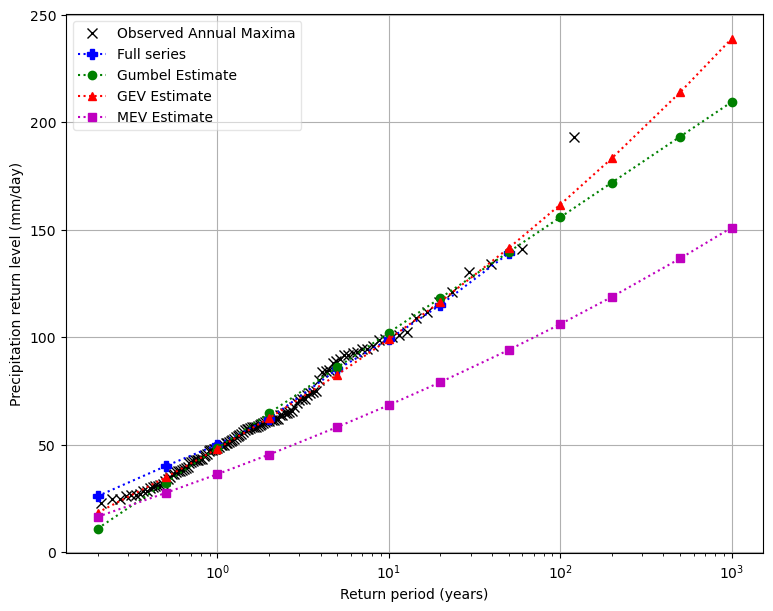

In [28]:
# Now we can expand our plot and compare all methods!
fig, ax = plt.subplots(figsize=(9,7))
ax.plot(T, df_max['PRCP'].values, \
        'xk', markersize=7, label='Observed Annual Maxima')
ax.plot(T_interest[:-4], full_series[:-4], ':Pb', markersize=7, label = 'Full series')
ax.plot(T_interest, gumbel_estimate, ':og', label = 'Gumbel Estimate')
ax.plot(T_interest, gev_estimate, ':^r', label='GEV Estimate')
ax.plot(T_interest, mev_estimate, ':sm', label='MEV Estimate')
ax.set_xlabel('Return period (years)')
ax.set_ylabel('Precipitation return level (mm/day)')
ax.set_xscale('log')
ax.legend(loc='best',framealpha=0.5)
ax.grid(True)


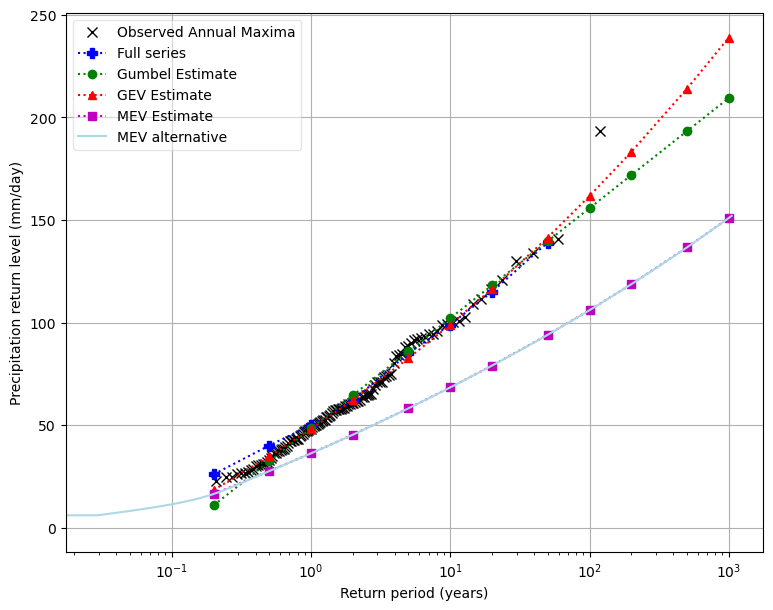

In [29]:
# bonus: with MEV alternative:
# return periods for the CDF curves
Ta_c = 1/(1-zeta)
T_c  = -1/(np.log(1-(1/Ta_c)))

fig, ax = plt.subplots(figsize=(9,7))
ax.plot(T, df_max['PRCP'].values, \
        'xk', markersize=7, label='Observed Annual Maxima')
ax.plot(T_interest[:-4], full_series[:-4], ':Pb', markersize=7, label = 'Full series')
ax.plot(T_interest, gumbel_estimate, ':og', label = 'Gumbel Estimate')
ax.plot(T_interest, gev_estimate, ':^r', label='GEV Estimate')
ax.plot(T_interest, mev_estimate, ':sm', label='MEV Estimate')
ax.plot(T_c[T_c<1100], dummy_X[T_c<1100], 'lightblue', label='MEV alternative')
ax.set_xlabel('Return period (years)')
ax.set_ylabel('Precipitation return level (mm/day)')
ax.set_xscale('log')
ax.legend(loc='best',framealpha=0.5)
ax.grid(True)

***What do you think of these lines? Take into account that MEV was not designed to fit the annual maxima, but rather to estimate extreme with return periods beyond the length of the observations (see Figure 3 in Zorzetto et al., 2016).***

*That's is for this practical, if you have time left you can work ahead with the last sections below*

## 6 Uncertainty analysis for GEV and MEV
In the plot you made during the previous practical you could see the difference in how the extreme precipitation is estimated using different methods. 

However, it is also important to know how senstive these estimates are. So in order to get an idea of the spread, create a testcase by randomly selecting 10 years of data. Calculate the 100-year return period using both the GEV and MEV distribution. Repeat this 500 times. 

Then make a plot to analyse the spread, for instance by boxplot. Also include the 100-year estimate of the GEV and MEV as calculated before.

Create your code in such a way that you can change the 100-year return period for another one, to see how sensitive the GEV and MEV are for both large and smaller return periods (e.g. 20, 50, 100, 500-years).

### 6.1 - Exercise: write a code for your testcase

In [30]:
# The following code could be used as a starting point:
ntimes     = 500
nyears     = 10
Tx         = 100 # the return period of interest
Fx         = np.exp(-(1/Tx))*(1/Tx)**0  # non-exceedence probability of interest 
                                        #- remember what we did in the beginning of this exercise

# empty variables for the GEV and MEV testcase estimates. 
# also, for the MEV function you need the variable 'flags', for the starting point of the numerial solution
gev_test   = []
mev_test   = []
flags_test = 0

# create a loop that runs ntimes (e.g. a while-loop or a for-loop)
for i in np.arange(ntimes):

    # randomly select nyears from the years in your data. The function 'random.sample' could be used for this
    
    # calculate the GEV estimate for these ten years:
    # 1 - randomly select 10 years from the AMS series created in 2
    
    # 2 - fit the three GEV parameters
    
    # 3 - calculate the GEV estimate 
    
    # save the gev estimate
    gev_test.append(gev_test_i)

    # calculate the MEV estimate for these ten years
    # 1 - randomly select 10 sets of MEV parameters (N,C and W for the same year) created above
    # 2 - give a starting point for the numerical solution (x0). 
    # 3 - calculate the MEV estimate: mev, flag = mev.mev_quant(Fx, x0, N, C, W)



    
    # if no flags have been raised, save the mev estimate
    if flag == True:
        print('A flag has been raised')
        flags_test += 1 # if too many flags have been raised, change the value of x0!
    elif flag == False:
        mev_test.append(mev_test_i)

NameError: name 'gev_test_i' is not defined

#### 6.2 - plot the results from your testcase
Create a graph that shows the spread. Examples of such a plot:
- Boxplot
- Figure 4 from Zorzetto et al. (2016)

In [ ]:
# exercise, plot the results of your testcase
boxplot_data = [gev_test, mev_test]

fig, ax = plt.subplots()
ax.boxplot(boxplot_data)
ax.plot(1, np.mean(gev_test), marker='^', color='r', label='GEV mean')
ax.plot(2, np.mean(mev_test), marker='s', color='m', label='MEV mean')
ax.xaxis.set_ticklabels(['GEV', 'MEV'])
ax.yaxis.set_label_text('Precipitation return level [mm/day]')
plt.title('Boxplot of the ' + str(Tx) + '-year return period using ' 
          + str(nyears) + ' random years repeated ' + str(ntimes) + ' times')

### 7 Exercise: reflective questions
1. Is GEV a better method than Gumbel? Explain your answer.

2. In which cases does the MEV provide an advantage over the GEV?

3. Which method of all methods do you think gives the most reliable estimate for precipitation that belongs to the 5 year return period?

4. Which method of all methods do you think gives the most reliable estimate for precipitation that belongs to the 1000 year return period?
